In [51]:
# %matplotlib widget
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import glob
from sunpy.coordinates import sun
from sunpy.sun import constants as const
from astropy.io import fits
from astropy import units as u 
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sunpy.net import Fido, attrs as a
from scipy.io import readsav
from sunpy.coordinates import frames
import numpy as np
import pandas as pd
from datetime import timedelta
from sunpy.time import parse_time
from astropy.visualization import ImageNormalize, SqrtStretch
from matplotlib import colors
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import importlib
import solar_data_utils as myfuncs
# Reload to update with new changes
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

In [2]:
pathdir = '/home/mnedal/data/nrh'

sav_files = sorted(glob.glob(f'{pathdir}/*.sav'))
print(*sav_files, sep='\n')

/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_150_9.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_173_2.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_228_0.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_298_7.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_327_5.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_408_0.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_432_0.sav


In [13]:
sav_files[-1]

'/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_432_0.sav'

In [ ]:
# Read NRH data
filename = sav_files[-2]
nrh = readsav(filename, python_dict=True)
i = 4 # zero is the start of the second
image_index = i + 240*2 # add 240 == 1 second

# getting header info for a given time index
b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}

# Constuct the NRH image
map_data = nrh['nrh_data'][image_index]

ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                     frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                     )
header = sunpy.map.make_fitswcs_header(map_data,
                                       ref_coord,
                                       reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                       scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                       wavelength=float(b['FREQ'])*u.MHz)
nrh_map = sunpy.map.Map(map_data, header)

In [ ]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=nrh_map)
img = nrh_map.plot(axes=ax, cmap='RdYlBu_r') # viridis, plasma, inferno, jet, hsv_r, RdYlBu_r
nrh_map.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Greys')
nrh_map.draw_limb(color='w')
nrh_map.draw_grid(color='w')
ax.grid(False)
ax.text(3, nrh_map.data.shape[1]-10, f'frame = {image_index}', color='black', fontsize=10, alpha=0.5)
fig.colorbar(img, ax=ax, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8')) # Decode bytes to string using UTF-8 encoding
fig.tight_layout()
plt.show()

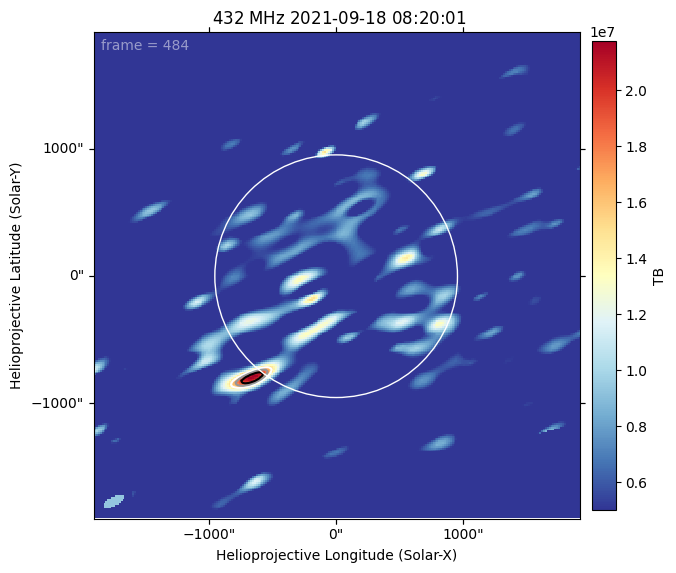

In [23]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=nrh_map)
img = nrh_map.plot(axes=ax, vmin=0.5e7, cmap='RdYlBu_r')
nrh_map.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Greys')
nrh_map.draw_limb(color='w')
ax.grid(False)
ax.text(3, nrh_map.data.shape[1]-10, f'frame = {image_index}', color='white', fontsize=10, alpha=0.5)
fig.colorbar(img, ax=ax, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
fig.tight_layout()
plt.show()

In [26]:
nrh_map.meta['date-obs']

'2021-09-18T08:20:01.250'

In [28]:
# Load AIA map
start_time = pd.Timestamp(nrh_map.meta['date-obs'])
end_time   = pd.Timestamp(nrh_map.meta['date-obs']) + timedelta(minutes=1)

aia_map = myfuncs.load_aia_single(data_dir=data_dir, start=start_time, end=end_time, level=1, channel=193)[0]

AIA 193A image 0 is loaded


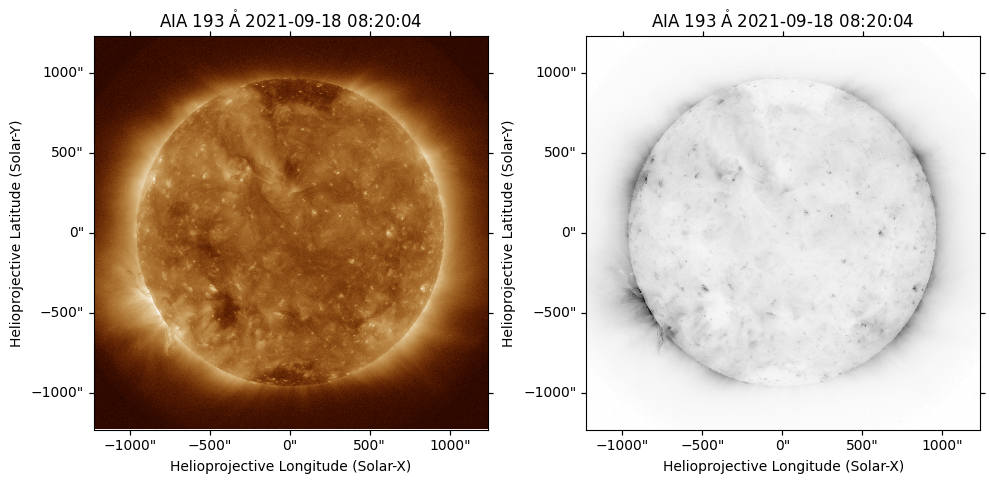

In [29]:
# Plot radio contours on AIA data
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(121, projection=aia_map)
aia_map.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(122, projection=aia_map)
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=SqrtStretch())
aia_map.plot(axes=ax, cmap='Greys')
ax.grid(False)

fig.tight_layout()
plt.show()

In [112]:
with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    nrh_map2 = nrh_map.reproject_to(aia_map.wcs)

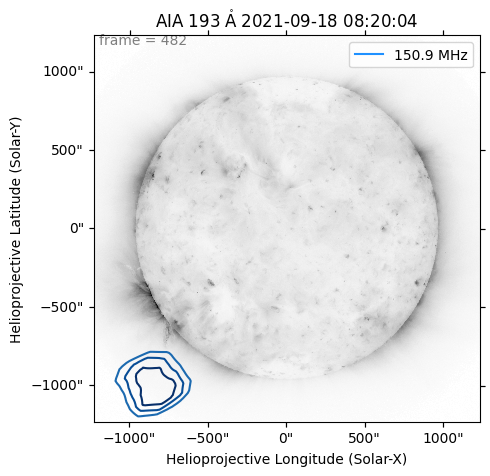

In [113]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(axes=ax, cmap='Greys')
nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Blues')
ax.text(50, aia_map.data.shape[1]-100, f'frame = {image_index}', color='black', fontsize=10, alpha=0.5)

# Make a proxy artist for the legend
contour_legend = mlines.Line2D([], [], color='dodgerblue', label=f"{nrh_map.meta['wavelnth']} MHz")
ax.legend(handles=[contour_legend])
ax.grid(False)
fig.tight_layout()
plt.show()

In [33]:
import matplotlib.cm as cm

# Define the colormaps you want to use
# colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlGnBu']
colormaps = ['YlGnBu', 'Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']

# Choose a value to sample from the colormap (0.5 is the middle)
sample_value = 0.5

# Create a dictionary to store the selected colors
selected_colors = {}

for cmap_name in colormaps:
    cmap = cm.get_cmap(cmap_name)   # Get the colormap object
    color = cmap(sample_value)      # Sample the color at the middle point
    selected_colors[cmap_name] = color

# Display the selected colors
for cmap_name, color in selected_colors.items():
    print(f"{cmap_name}: {color}")

YlGnBu: (0.2526874279123414, 0.7114494425221068, 0.7683813917723953, 1.0)
Reds: (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0)
Oranges: (0.9914186851211073, 0.550726643598616, 0.23277201076509035, 1.0)
Greens: (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0)
Blues: (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0)
Purples: (0.617762399077278, 0.6021376393694733, 0.7834525182622069, 1.0)
Greys: (0.586082276047674, 0.586082276047674, 0.586082276047674, 1.0)


In [32]:
# Read NRH data
nrh_maps = []
# add 240 == 1 second
i = 4 # zero is the start of the second
image_index = i + 240*2

with tqdm(total=len(sav_files), desc='Loading NRH maps ...') as pbar:
    for i, filename in enumerate(sav_files):
        nrh = readsav(filename, python_dict=True)
        
        # getting header info for a given time index
        b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}
        map_data = nrh['nrh_data'][image_index] # Constuct the NRH image
        ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                             frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                             )
        header = sunpy.map.make_fitswcs_header(map_data,
                                               ref_coord,
                                               reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                               scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                               wavelength=float(b['FREQ'])*u.MHz)
        nrh_map = sunpy.map.Map(map_data, header)
        nrh_maps.append(nrh_map)
        pbar.update(1)

Loading NRH maps ...: 100%|████████████████████████████████████████████████████| 7/7 [02:35<00:00, 22.27s/it]


Loading NRH maps ...: 100%|███████████████████████████████████████████████████| 7/7 [11:54<00:00, 102.13s/it]


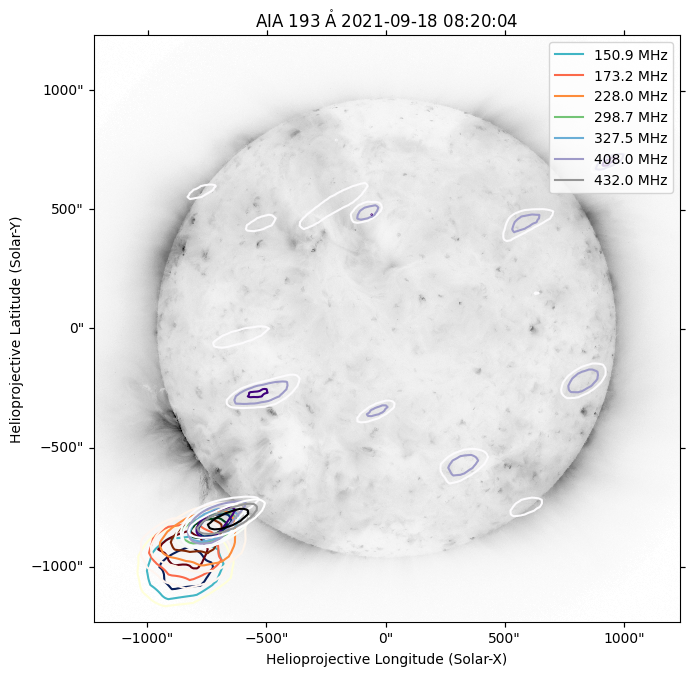

In [34]:
# Plot the contours of all frequencies of NRH on AIA map
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(axes=ax, cmap='Greys')
# ax.text(50, aia_map.data.shape[1]-100, f'frame = {image_index}', color='black', fontsize=10, alpha=0.5)

handles = []

# Read NRH data
with tqdm(total=len(nrh_maps), desc='Loading NRH maps ...') as pbar:
    for i, nrh_map in enumerate(nrh_maps):
        with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
            nrh_map2 = nrh_map.reproject_to(aia_map.wcs)
        nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap=colormaps[i])
        
        # Make a proxy artist for the legend
        contour_legend = mlines.Line2D([], [], color=selected_colors[colormaps[i]], label=f"{nrh_map.meta['wavelnth']} MHz")
        handles.append(contour_legend)
        pbar.update(1)

# aia_map.draw_limb(color='k')
ax.grid(False)
ax.legend(handles=handles)
fig.tight_layout()
fig.savefig(f"{data_dir}/plots/AIA_NRH_{nrh_map.meta['date-obs']}.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Apply PFSS Model

In [39]:
import pfsspy
import pfsspy.tracing as tracing

In [42]:
mydatetime = '2021-09-18T08:15:00'

mydate, mytime = mydatetime.split('T')
year, month, day = mydate.split('-')
hour, minute, second = mytime.split(':')

# get the Carrington rotation number at the specified datetime 
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))
print(f'CR: {cr}')

CR: 2248


In [43]:
# show the links of the GONG files
gong_url = f'https://gong2.nso.edu/oQR/zqs/{year}{month}/mrzqs{year[-2:]}{month}{day}/'
list_gong_links = myfuncs.find_links(url=gong_url)

# show what is in there
for i, link in enumerate(list_gong_links):
    print(i, link)

0 ?C=N;O=D
1 ?C=M;O=A
2 ?C=S;O=A
3 ?C=D;O=A
4 /oQR/zqs/202109/
5 mrzqs210918t0014c2248_027.fits.gz
6 mrzqs210918t0104c2248_026.fits.gz
7 mrzqs210918t0204c2248_026.fits.gz
8 mrzqs210918t0314c2248_025.fits.gz
9 mrzqs210918t0334c2248_025.fits.gz
10 mrzqs210918t0504c2248_024.fits.gz
11 mrzqs210918t0604c2248_024.fits.gz
12 mrzqs210918t0704c2248_023.fits.gz
13 mrzqs210918t0814c2248_022.fits.gz
14 mrzqs210918t0914c2248_022.fits.gz
15 mrzqs210918t1014c2248_021.fits.gz
16 mrzqs210918t1104c2248_021.fits.gz
17 mrzqs210918t1214c2248_020.fits.gz
18 mrzqs210918t1304c2248_020.fits.gz
19 mrzqs210918t1404c2248_019.fits.gz
20 mrzqs210918t1514c2248_019.fits.gz
21 mrzqs210918t1614c2248_018.fits.gz
22 mrzqs210918t1714c2248_017.fits.gz
23 mrzqs210918t1814c2248_017.fits.gz
24 mrzqs210918t1904c2248_016.fits.gz
25 mrzqs210918t2014c2248_016.fits.gz
26 mrzqs210918t2114c2248_015.fits.gz
27 mrzqs210918t2204c2248_015.fits.gz
28 mrzqs210918t2304c2248_014.fits.gz


In [48]:
gong_file_index = 13
gong_filename = list_gong_links[gong_file_index]

# make sure there is a data diretory to store the files
os.makedirs(f'{data_dir}/GONG', exist_ok=True)
print(f'{data_dir}/GONG/{gong_filename}')

/home/mnedal/data/GONG/mrzqs210918t0814c2248_022.fits.gz


In [49]:
if not os.path.exists(f'{data_dir}/GONG/{gong_filename[:-3]}') and not os.path.exists(f'{data_dir}/GONG/{gong_filename}'):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=f'{data_dir}/GONG/{gong_filename}')

if not os.path.exists(f'{data_dir}/GONG/{gong_filename[:-3]}'):
    with gzip.open(f'{data_dir}/GONG/{gong_filename}', 'rb') as f:
        with open(f'{data_dir}/GONG/{gong_filename[:-3]}', 'wb') as g:
            g.write(f.read())

# make a sunpy map of the file
gong_map = sunpy.map.Map(f'{data_dir}/GONG/{gong_filename[:-3]}')

# fix a bug in the GONG map file
if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = u.deg

# find where is the Earth LOS on GONG map
hp_lon = 0*u.arcsec
hp_lat = np.linspace(-970, 970, 30)*u.arcsec

# Make a 2D grid from these 1D points
lon, lat = np.meshgrid(hp_lon, hp_lat)
earth_los = SkyCoord(lon.ravel(), lat.ravel(), frame=aia_map.coordinate_frame)
los_lon = sun.L0(time=aia_map.meta['date-obs']).value
print(f'Carrington longitude: {los_lon}')

Carrington longitude: 82.34555031635125


In [65]:
# The PFSS solution is calculated on a regular 3D grid in (phi, s, rho), where rho = ln(r), 
# and r is the standard spherical radial coordinate.
# We need to define the number of grid points in rho, and the source surface radius.
# From the boundary condition, number of radial grid points, and source surface, 
# we now construct an `Input` object that stores this information.
# Using the `Input` object, plot the input photospheric magnetic field.
rss = 3   # source surface radius
nrho = 50 # number of rho grid points
r = 1.1*const.radius # The height at which field line tracing is started, in solar radii

pfss_in = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

# Now we construct a lat x lon grid of footpoitns to trace some magnetic field lines from. 
# These coordinates are defined in the helioprojective frame of the AIA image.
num_footpoints = 50
lat = np.linspace(np.radians(-85), np.radians(85), num_footpoints, endpoint=False)
lon = np.linspace(np.radians(-30), np.radians(180), num_footpoints, endpoint=False)

# # ONLY AT THE EARTH LOS
# lat = np.linspace(np.radians(-85), np.radians(85), num_footpoints, endpoint=False)
# lon = np.linspace(np.radians(los_lon-5), np.radians(los_lon+5), 5, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad

# Make a 2D grid from these 1D points
seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [ ]:
# Plot the magnetogram and the seed footpoints
m = pfss_in.map

fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=m)
gon = m.plot()
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2, label='PFSS seeds')
ax.plot_coord(earth_los, color='crimson', marker='*', linewidth=0, markersize=5, label='Earth LOS')
ax.legend(loc='best')
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, cmap='gray_r')
ax.plot_coord(seeds, color='navy', marker='o', linewidth=0, markersize=2, label='PFSS seeds')
ax.plot_coord(earth_los, color='crimson', marker='*', linewidth=0, markersize=5, label='Earth LOS')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [68]:
# tracer = tracing.FortranTracer(max_steps=20000, step_size=1)
tracer = tracing.FortranTracer()
# tracer = tracing.PythonTracer()
flines = tracer.trace(seeds, pfss_out)

In [ ]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, cmap='gray_r')

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for fline in flines:
        color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(fline.polarity)
        if fline.polarity == 0:
            alpha = 0.2
        else:
            alpha = 0.7
        ax.plot_coord(fline.coords, alpha=alpha, color=color, linewidth=1)
        pbar.update(1)

# ax.set_xlim(left=0, right=int(aia_map.dimensions.x.value))
# ax.set_ylim(bottom=0, top=int(aia_map.dimensions.y.value))
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, cmap='gray_r')

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for fline in flines:
        color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(fline.polarity)
        if fline.polarity == 0:
            alpha = 0.2
        else:
            alpha = 0.7
        ax.plot_coord(fline.coords, alpha=alpha, color=color, linewidth=1)
        pbar.update(1)

# ax.set_xlim(left=0, right=int(aia_map.dimensions.x.value))
# ax.set_ylim(bottom=0, top=int(aia_map.dimensions.y.value))
ax.set_xlim(left=0, right=1500)
ax.set_ylim(bottom=0, top=2000)
fig.tight_layout()
plt.show()

Loading NRH maps ...: 100%|███████████████████████████████████████████████████| 7/7 [11:55<00:00, 102.15s/it]


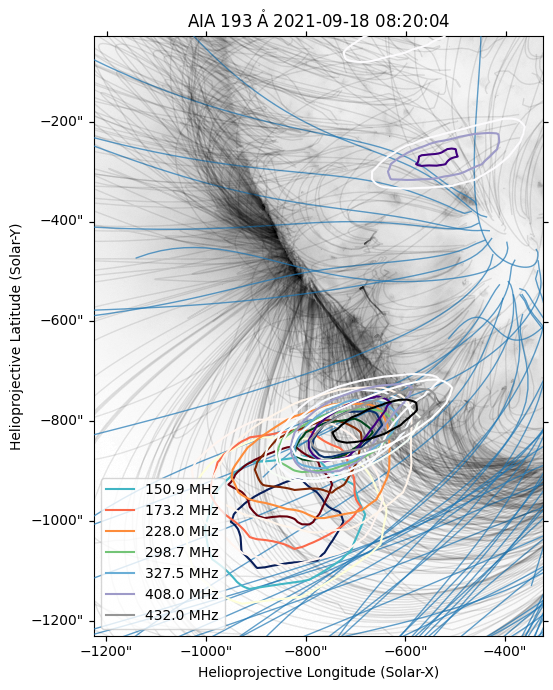

In [71]:
# Plot the contours of all frequencies of NRH on AIA map
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(axes=ax, cmap='Greys')

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for fline in flines:
        color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(fline.polarity)
        if fline.polarity == 0:
            alpha = 0.1
        else:
            alpha = 0.7
        ax.plot_coord(fline.coords, alpha=alpha, color=color, linewidth=1)
        pbar.update(1)

# Read NRH data
handles = []
with tqdm(total=len(nrh_maps), desc='Loading NRH maps ...') as pbar:
    for i, nrh_map in enumerate(nrh_maps):
        with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
            nrh_map2 = nrh_map.reproject_to(aia_map.wcs)
        nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap=colormaps[i])
        
        # Make a proxy artist for the legend
        contour_legend = mlines.Line2D([], [], color=selected_colors[colormaps[i]], label=f"{nrh_map.meta['wavelnth']} MHz")
        handles.append(contour_legend)
        pbar.update(1)

ax.grid(False)
ax.legend(loc='best', handles=handles)
ax.set_xlim(left=0, right=1500)
ax.set_ylim(bottom=0, top=2000)
fig.tight_layout()
fig.savefig(f"{data_dir}/plots/AIA_NRH_PFSS_{nrh_map.meta['date-obs']}.pdf", format='pdf', bbox_inches='tight')
plt.show()